# Inaugural Project #



In [49]:
#Import 
from types import SimpleNamespace

import numpy as np
from scipy import optimize

import pandas as pd 
import matplotlib.pyplot as plt


In [50]:
class HouseholdSpecializationModelClass:

    def __init__(self):
        """ setup model """

        # a. create namespaces
        par = self.par = SimpleNamespace()
        sol = self.sol = SimpleNamespace()

        # b. preferences
        par.rho = 2.0
        par.nu = 0.001
        par.epsilon = 1.0
        par.omega = 0.5 

        # c. household production
        par.alpha = 0.5
        par.sigma = 1.0

        # d. wages
        par.wM = 1.0
        par.wF = 1.0
        par.wF_vec = np.linspace(0.8,1.2,5)

        # e. targets
        par.beta0_target = 0.4
        par.beta1_target = -0.1

        # f. solution
        sol.LM_vec = np.zeros(par.wF_vec.size)
        sol.HM_vec = np.zeros(par.wF_vec.size)
        sol.LF_vec = np.zeros(par.wF_vec.size)
        sol.HF_vec = np.zeros(par.wF_vec.size)

        sol.beta0 = np.nan
        sol.beta1 = np.nan

    def calc_utility(self,LM,HM,LF,HF):
        """ calculate utility """

        par = self.par
        sol = self.sol

        # a. consumption of market goods
        C = par.wM*LM + par.wF*LF

        # b. home production
        H = np.nan
        if par.sigma == 0:
            H = np.fmin(HM, HF)
        elif par.sigma == 1:
            H = HM**(1-par.alpha)*HF**par.alpha
        else:
            H = ((1-par.alpha)*HM**((par.sigma-1)/(par.sigma)) + par.alpha*HF**((par.sigma-1)/(par.sigma)))**(par.sigma/(par.sigma-1))

        # c. total consumption utility
        Q = C**par.omega*H**(1-par.omega)
        utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)

        # d. disutlity of work
        epsilon_ = 1+1/par.epsilon
        TM = LM+HM
        TF = LF+HF
        disutility = par.nu*(TM**epsilon_/epsilon_+TF**epsilon_/epsilon_)
        
        return utility - disutility

    def solve_discrete(self,do_print=False):
        """ solve model discretely """
        
        par = self.par
        sol = self.sol
        opt = SimpleNamespace()
        
        # a. all possible choices
        x = np.linspace(0,24,49)
        LM,HM,LF,HF = np.meshgrid(x,x,x,x) # all combinations
    
        LM = LM.ravel() # vector
        HM = HM.ravel()
        LF = LF.ravel()
        HF = HF.ravel()

        # b. calculate utility
        u = self.calc_utility(LM,HM,LF,HF)
    
        # c. set to minus infinity if constraint is broken
        I = (LM+HM > 24) | (LF+HF > 24) # | is "or"
        u[I] = -np.inf
    
        # d. find maximizing argument
        j = np.argmax(u)
        
        opt.LM = LM[j]
        opt.HM = HM[j]
        opt.LF = LF[j]
        opt.HF = HF[j]

        # e. print
        if do_print:
            for k,v in opt.__dict__.items():
                print(f'{k} = {v:6.4f}')

        return opt

   def solve(self,do_print=False):
        """ solve model continously """

        #par = self.par
        #sol = self.sol
        opt = SimpleNamespace()

        # define objective function to maximize
        def objective(x):
            LM, HM, LF, HF = x
            return -self.calc_utility(LM, HM, LF, HF)

        # define constraints and bounds
        def constraints(x):
            LM, HM, LF, HF = x
            return [24 - LM - HM, 24 - LF - HF]
        
        constraints = ({'type':'ineq', 'fun': constraints})
        bounds = ((0,24),(0,24),(0,24),(0,24))

        # initial guess
        initial_guess = [6, 6, 6, 6]

        # call solver
        solution = optimize.minimize(
            objective, initial_guess, 
            method='SLSQP', 
            bounds=bounds, 
            constraints=constraints
            )
        
        opt.LM, opt.HM, opt.LF, opt.HF = solution.x

        return opt
   

    def solve_wF_vec(self,discrete=False):
        """ solve model for vector of female wages """

        par = self.par
        sol = self.sol

        # fill out solution vectors for HF and HM
        for i, wF in enumerate(par.wF_vec):
            par.wF = wF
            optimum = self.solve()
            sol.HF_vec[i] = optimum.HF
            sol.HM_vec[i] = optimum.HM
            sol.LF_vec[i] = optimum.LF
            sol.LM_vec[i] = optimum.LM
        
        return sol.HF_vec, sol.HM_vec, sol.LF_vec, sol.LM_vec


    def run_regression(self):
        """ run regression """

        par = self.par
        sol = self.sol
        
        self.solve_wF_vec()

        x = np.log(par.wF_vec)
        y = np.log(sol.HF_vec/sol.HM_vec)
        A = np.vstack([np.ones(x.size),x]).T

        sol.beta0,sol.beta1 = np.linalg.lstsq(A,y,rcond=None)[0]

        return sol.beta0,sol.beta1
    
    def estimate(self,alpha=None,sigma=None):
        """ estimate alpha and sigma """
        
        par = self.par
        sol = self.sol

        # define objective function to minimize
        def objective(x):
            alpha, sigma = x
            par.alpha = alpha
            par.sigma = sigma
            self.solve_wF_vec()
            self.run_regression()
            return (par.beta0_target - sol.beta0)**2+(par.beta1_target - sol.beta1)**2
        
        # initial guess
        initial_guess = [0.5, 1.0]

        # call solver
        solution = optimize.minimize(objective, initial_guess, method='Nelder-Mead')

        alpha_min, sigma_min = solution.x

        return alpha_min, sigma_min 

# Question 1 #

In [51]:
# Define the necessary parameters
alpha_list = [0.25, 0.50, 0.75]
sigma_list = [0.5, 1.0, 1.5]

# initialize dictionary to store results
resultsHF = {}
resultsHM = {}
resultsHFHNM = {}

# foreach combination of alpha and sigma, print the ratio of optimal HF/HM
for alpha in alpha_list:    
    for sigma in sigma_list:
        # set new values for alpha and sigma
        model = HouseholdSpecializationModelClass()
        model.par.alpha = alpha
        model.par.sigma = sigma

        # solve the model
        opt = model.solve_discrete()
        # store the result
        resultsHF[(alpha, sigma)] = opt.HF
        resultsHM[(alpha, sigma)] = opt.HM
        resultsHFHNM[(alpha, sigma)] = opt.HF/opt.HM

        # print results
        print(f"with an alpha = {alpha} and a sigma = {sigma}, we get that HF/HM = {opt.HF:.2f} / {opt.HM:.2f} = {opt.HF/opt.HM:.2f}")

/var/folders/9j/v95rb3md0v72jhphm0mh6thr0000gn/T/ipykernel_23018/622058312.py:52: RuntimeWarning: invalid value encountered in reciprocal
  utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)


with an alpha = 0.25 and a sigma = 0.5, we get that HF/HM = 2.00 / 6.50 = 0.31
with an alpha = 0.25 and a sigma = 1.0, we get that HF/HM = 2.00 / 6.50 = 0.31
with an alpha = 0.25 and a sigma = 1.5, we get that HF/HM = 2.00 / 6.50 = 0.31
with an alpha = 0.5 and a sigma = 0.5, we get that HF/HM = 4.50 / 4.50 = 1.00
with an alpha = 0.5 and a sigma = 1.0, we get that HF/HM = 4.50 / 4.50 = 1.00
with an alpha = 0.5 and a sigma = 1.5, we get that HF/HM = 4.50 / 4.50 = 1.00
with an alpha = 0.75 and a sigma = 0.5, we get that HF/HM = 6.50 / 2.00 = 3.25
with an alpha = 0.75 and a sigma = 1.0, we get that HF/HM = 6.50 / 2.00 = 3.25
with an alpha = 0.75 and a sigma = 1.5, we get that HF/HM = 6.50 / 2.00 = 3.25


# Question 2 #

The wages for females are [0.8 0.9 1.  1.1 1.2]


/var/folders/9j/v95rb3md0v72jhphm0mh6thr0000gn/T/ipykernel_23018/622058312.py:52: RuntimeWarning: invalid value encountered in reciprocal
  utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)


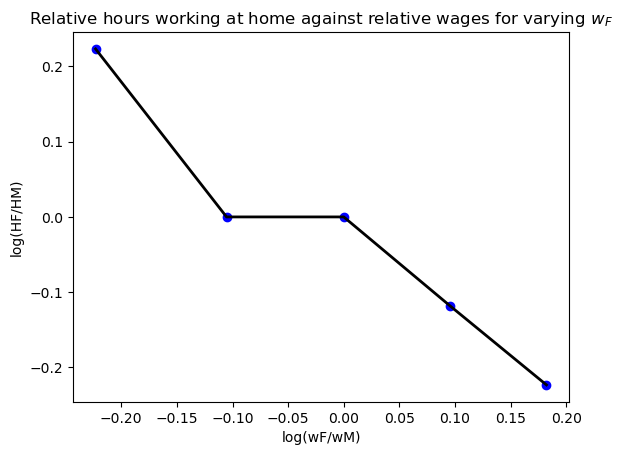

In [52]:
import numpy as np
from types import SimpleNamespace

# 1. Create an instance of the HouseholdSpecializationModelClass
model = HouseholdSpecializationModelClass()

# 2. Define the vector of wage rates
wf = model.par.wF_vec
print(f"The wages for females are {wf}")
           
# 3. Create an empty array to store the optimal labor supply
temp_ratio= np.zeros_like(wf)

# 4. Loop over the wage rates and find the optimal labor supply
for i, wage in enumerate(wf):
    model.par.wF = wage
    opt = model.solve_discrete()
    ratio = opt.HF/opt.HM
    temp_ratio[i]=ratio

    # 5. Print or plot the results
    #print(ratio)
   
# 6. Plot the results
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.log(wf), np.log(temp_ratio), color='black', lw=2) # the famale wage is equal to the relative becuase wM = 1
plt.xlabel("log(wF/wM)")
plt.ylabel("log(HF/HM)")
plt.title("Relative hours working at home against relative wages for varying $w_F$")

# 6. Add data points
x_data = np.log(np.linspace(0.8, 1.2, 5))
y_data = np.log(temp_ratio[:5])
plt.scatter(x_data, y_data, color='blue')

# 7. Show the graph
plt.show()

# Question 3 #

In [53]:
m3 = HouseholdSpecializationModelClass()

log_Hratio = []
log_wratio =[]

for wF in m3.par.wF_vec:
    m3.par.wF = wF
    optimum = m3.solve()
    log_HFM = np.log(optimum.HF/optimum.HM)
    log_Hratio = np.append(log_Hratio, log_HFM)
    log_wF = np.log(wF/m3.par.wM)
    log_wratio = np.append(log_wratio, log_wF)
    print(wF, log_HFM, log_wF)

AttributeError: 'NoneType' object has no attribute 'HF'

In [ ]:
# creating figure
fig = plt.figure()
# creating plot
ax = fig.add_subplot(1, 1, 1)
ax.plot(log_wratio, log_Hratio, color='black', lw=2)
# making alterations to the figure
ax.grid()
ax.set_xlabel("log(wF/wM)")
ax.set_ylabel("log(HF/HM)")
ax.set_title("Plot of log(HF/HM) against log(wF/wM) for different values of wF")
plt.show()

# Question 4 #

In [ ]:
m4 = HouseholdSpecializationModelClass()
m4.estimate()
print(f'(alpha, sigma) = {m4.estimate()}')

# including minimizing alpha and sigma
log_Hratio = []
log_wratio =[]

for wF in m4.par.wF_vec:
    m4.par.wF = wF
    optimum = m4.solve()
    log_HFM = np.log(optimum.HF/optimum.HM)
    log_Hratio = np.append(log_Hratio, log_HFM)
    log_wF = np.log(wF/m4.par.wM)
    log_wratio = np.append(log_wratio, log_wF)


# Siminski and Yetsenga's regression line
def f(log_wratio):
    return 0.4 +(-0.1)*log_wratio


# creating the figure
fig = plt.figure()
# creating the plot
ax = fig.add_subplot(1, 1, 1)
ax.plot(log_wratio, f(log_wratio))
ax.scatter(log_wratio, log_Hratio, color='black')

# making alterations to the figure
ax.grid()
ax.set_xlabel("log(wF/wM)")
ax.set_ylabel("log(HF/HM)")
ax.set_title("")
plt.show()